In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode

In [2]:
# -------------------------- Data Loading and Preprocessing --------------------------

# Load the dataset
file_path = r'D:\hash_functions_results.csv'  # Adjust as necessary
hash_functions_df = pd.read_csv(file_path)

# Print column names to ensure they match expected names
print(hash_functions_df.columns)

# Encode the 'Hash Function' column
label_encoder = LabelEncoder()
hash_functions_df['Hash Function'] = label_encoder.fit_transform(hash_functions_df['Hash Function'])

# Calculate Resistance to Cryptographic Attacks as the average of Per-Image and Second-Per-Image Resistance
hash_functions_df['Resistance to Cryptographic Attacks'] = (
    hash_functions_df['Per-Image Resistance'] + hash_functions_df['Second-per-Image Resistance (s)']
) / 2

# Select the specific columns we need as features
X = hash_functions_df[['Collisions', 'Entropy', 'Efficiency Score', 'Resistance to Cryptographic Attacks']]
y = hash_functions_df['Hash Function']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Index(['Iteration', 'Hash Function', 'Speed (s)', 'Collisions',
       'Per-Image Resistance', 'Second-per-Image Resistance (s)', 'Entropy',
       'Memory Usage (MiB)', 'Efficiency Score'],
      dtype='object')


In [3]:
# -------------------------- Handle Class Imbalance --------------------------

# Calculate class weights to handle imbalance (if any)
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Get the number of unique classes for the output layer
num_classes = len(label_encoder.classes_)

In [4]:
# -------------------------- Model Creation Function --------------------------

def create_model(optimizer='adam', learning_rate=0.001):
    """Creates and compiles a Keras Sequential model."""
    model = Sequential([
        Dense(64, input_dim=X_train.shape[1], kernel_initializer='glorot_uniform', activation='relu'),
        Dense(32, kernel_initializer='glorot_uniform', activation='relu'),
        Dense(num_classes, kernel_initializer='glorot_uniform', activation='softmax')
    ])
    
    # Choose optimizer
    if optimizer == 'adam':
        optimizer_instance = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer_instance = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer_instance, metrics=['accuracy'])
    return model

In [5]:
# -------------------------- Hyperparameter Tuning with GridSearchCV --------------------------

# EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Initialize KerasClassifier with early stopping
model = KerasClassifier(
    model=create_model, 
    epochs=100, 
    batch_size=10, 
    verbose=0, 
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

# Define parameter grid for GridSearchCV
param_grid = {
    'model__optimizer': ['adam', 'rmsprop'],
    'epochs': [50, 100],
    'batch_size': [10, 20]
}

# Perform GridSearchCV with stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# Display the best parameters and accuracy
print("Best Accuracy: {:.2f}%".format(grid_result.best_score_ * 100))
print("Best Parameters: ", grid_result.best_params_)


C:\Users\REPA IT SOLUTION\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\REPA IT SOLUTION\AppData\Roaming\Python\Python311\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


Best Accuracy: 100.00%
Best Parameters:  {'batch_size': 20, 'epochs': 100, 'model__optimizer': 'adam'}


In [6]:
# -------------------------- Model Evaluation --------------------------

# Get the best model from the grid search
best_model = grid_result.best_estimator_

# Predict on the test set
y_pred = best_model.model_.predict(X_test).argmax(axis=1)

# Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Confusion Matrix:
[[108   0   0   0   0]
 [  0 110   0   0   0]
 [  0   0  92   0   0]
 [  0   0   0 104   0]
 [  0   0   0   0  86]]

Classification Report:
              precision    recall  f1-score   support

         MD5       1.00      1.00      1.00       108
     SHA-256       1.00      1.00      1.00       110
   SHA-3-256       1.00      1.00      1.00        92
   SHA-3-512       1.00      1.00      1.00       104
     SHA-512       1.00      1.00      1.00        86

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



In [7]:
# -------------------------- Save the Best Model --------------------------

# Save the best model to a file
best_model.model_.save("best_hash_classifier_model.h5")
print("\nModel saved as 'best_hash_classifier_model.h5'")



Model saved as 'best_hash_classifier_model.h5'


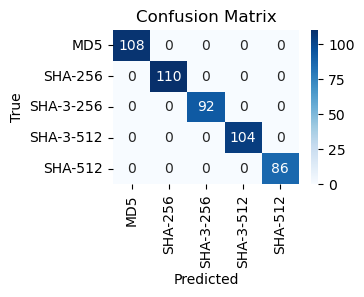

In [8]:
# -------------------------- Visualizing the Results --------------------------

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 2))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [9]:
# -------------------------- Determine the Optimal Hash Function --------------------------
# Decode the predicted labels
y_pred = best_model.model_.predict(X_test).argmax(axis=1)

# Get the mode of predictions (most frequent predicted class)
# We add a condition to handle cases where mode returns a scalar
optimal_hash_function_index = mode(y_pred).mode
if isinstance(optimal_hash_function_index, np.ndarray):
    optimal_hash_function_index = optimal_hash_function_index[0]

# Decode the optimal hash function index back to its name
optimal_hash_function = label_encoder.inverse_transform([optimal_hash_function_index])[0]

print("\nOptimal Hash Function based on classification results: ", optimal_hash_function)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Optimal Hash Function based on classification results:  SHA-256
